<a href="https://colab.research.google.com/github/swapnamoy007/ML-ASSIGNMENT/blob/main/Module_7/MidTerm_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MidTerm - 2 for the Fall 2024 Course "Machine Learning for Materials Science", University of Tennessee Knoxville, Department of Materials Science and Engineering.

- Instructor Sergei V. Kalinin

Special point:
- ChatGPT will augment your power as a coder
- If and only if you know what you want to accomplish!

# 1.Out-of-distribution effects

Explore the out of distribution effects in VAE.
- Build the VAE or AE denoiser
- Train it on the digits [0-5]
- Quantufy performance on the digits that it was trained on (e.g. vis SSID of ground truth vs reconstruction as a function of noise)
- Quantify performance for digits [6-9]

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from skimage.metrics import structural_similarity as ssim
import numpy as np

# 1. Define the Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Define encoder and decoder layers
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 28*28), nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


# 2. Prepare Data
def load_data(digits):
    transform = transforms.Compose([transforms.ToTensor(), lambda x: x.view(-1)])
    full_data = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
    data_subset = [(x, y) for x, y in full_data if y in digits]
    return data_subset


# 3. Train the Model
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    for epoch in range(epochs):
        model.train()
        for x, _ in train_loader:
            x_noisy = x + torch.randn_like(x) * 0.2  # Add noise
            x_noisy = torch.clip(x_noisy, 0, 1)  # Ensure values are in [0, 1]
            optimizer.zero_grad()
            reconstruction = model(x_noisy)
            loss = criterion(reconstruction, x)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


# 4. Evaluate SSIM
def evaluate_ssim(model, data_loader):
    model.eval()
    ssim_scores = []
    for x, _ in data_loader:
        x_noisy = x + torch.randn_like(x) * 0.2  # Add noise
        x_noisy = torch.clip(x_noisy, 0, 1)  # Ensure pixel values remain in [0, 1]
        reconstruction = model(x_noisy).detach()

        for i in range(len(x)):
            original = x[i].view(28, 28).numpy()
            recon = reconstruction[i].view(28, 28).numpy()
            # Compute SSIM with data_range=1.0
            ssim_scores.append(ssim(original, recon, data_range=1.0))
    return np.mean(ssim_scores)


# Main Execution
if __name__ == "__main__":
    # Load and prepare data
    train_data_in = load_data(digits=[0, 1, 2, 3, 4, 5])
    test_data_in = load_data(digits=[0, 1, 2, 3, 4, 5])
    test_data_ood = load_data(digits=[6, 7, 8, 9])

    train_loader = torch.utils.data.DataLoader(train_data_in, batch_size=64, shuffle=True)
    test_loader_in = torch.utils.data.DataLoader(test_data_in, batch_size=64, shuffle=False)
    test_loader_ood = torch.utils.data.DataLoader(test_data_ood, batch_size=64, shuffle=False)

    # Initialize model, loss, optimizer
    model = Autoencoder()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_model(model, train_loader, criterion, optimizer, epochs=20)

    # Evaluate SSIM for in-distribution and OOD digits
    ssim_in = evaluate_ssim(model, test_loader_in)
    ssim_ood = evaluate_ssim(model, test_loader_ood)

    print(f"SSIM (In-distribution): {ssim_in}")
    print(f"SSIM (Out-of-distribution): {ssim_ood}")


Epoch 1, Loss: 0.038052283227443695
Epoch 2, Loss: 0.02721397764980793
Epoch 3, Loss: 0.02490108460187912
Epoch 4, Loss: 0.025554656982421875
Epoch 5, Loss: 0.01969143934547901
Epoch 6, Loss: 0.01616157963871956
Epoch 7, Loss: 0.017643529921770096
Epoch 8, Loss: 0.01819848269224167
Epoch 9, Loss: 0.01646335981786251
Epoch 10, Loss: 0.01617186702787876
Epoch 11, Loss: 0.013702217489480972
Epoch 12, Loss: 0.013227363117039204
Epoch 13, Loss: 0.014739157631993294
Epoch 14, Loss: 0.015314447693526745
Epoch 15, Loss: 0.012865971773862839
Epoch 16, Loss: 0.013934683986008167
Epoch 17, Loss: 0.012445760890841484
Epoch 18, Loss: 0.013418443500995636
Epoch 19, Loss: 0.012973623350262642
Epoch 20, Loss: 0.0121916513890028
SSIM (In-distribution): 0.8588139116590073
SSIM (Out-of-distribution): 0.7723518640632255


# 2.Explainable ML

- Build the classified for the fashion MNIST data set
- Use LIME or SHAP to explain the predictions

In [6]:
!pip install lime

In [28]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt

# Load Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Classes in Fashion MNIST
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class FashionMNISTClassifier(nn.Module):
    def __init__(self):
        super(FashionMNISTClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

model = FashionMNISTClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")
# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")


# Define a prediction function for LIME
def predict(images):
    model.eval()
    images = torch.tensor(images).permute(0, 3, 1, 2)  # Reshape for PyTorch
    outputs = model(images.float())
    return outputs.softmax(dim=1).detach().numpy()

# LIME Explainer
explainer = lime_image.LimeImageExplainer()
images, labels = next(iter(test_loader))
image = images[0].numpy().transpose(1, 2, 0)

# Explain a single prediction
explanation = explainer.explain_instance(
    image, predict, top_labels=1, hide_color=0, num_samples=1000
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False
)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"Class: {classes[explanation.top_labels[0]]}")
plt.axis('off')
plt.show()


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.3MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 173kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.27MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.74MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch 1/5, Loss: 0.4964
Epoch 2/5, Loss: 0.3667
Epoch 3/5, Loss: 0.3316
Epoch 4/5, Loss: 0.3051
Epoch 5/5, Loss: 0.2881
Accuracy: 87.92%


ValueError: Only RGB images can be converted to Lab space.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Step 1: Define the Model
class FashionMNISTClassifier(nn.Module):
    def __init__(self):
        super(FashionMNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Add a method to calculate the fully connected layer input size
        self.flatten_size = None  # Placeholder, will be set during model initialization
        self.fc1 = None  # Placeholder, will be initialized dynamically
        self.fc2 = nn.Linear(128, 10)  # Final output

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        if self.flatten_size is None:
            self.flatten_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flatten_size, 128).to(x.device)
        x = x.view(-1, self.flatten_size)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Step 2: Load the Fashion MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# Step 3: Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FashionMNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Step 4: Test the Model
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Step 5: LIME Explanation
# Convert a grayscale image to pseudo-RGB
image, label = test_data[0]
image = image.numpy()

image_rgb = np.stack([image.squeeze()] * 3, axis=-1)  # Convert (1, 28, 28) -> (28, 28, 3)

# Define prediction function
def predict(images):
    images = np.mean(images, axis=-1, keepdims=True)  # Convert RGB to grayscale
    images = torch.tensor(images).permute(0, 3, 1, 2).float().to(device)  # Reshape for PyTorch
    outputs = model(images)
    return outputs.softmax(dim=1).detach().cpu().numpy()

# LIME explainer
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image_rgb, predict, top_labels=1, hide_color=0, num_samples=1000
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False
)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"Class: {train_data.classes[explanation.top_labels[0]]}")
plt.axis('off')
plt.show()


ValueError: Expected input batch_size (256) to match target batch_size (64).

In [29]:
pip install shap

In [ ]:
import shap

# Define SHAP explainer
explainer = shap.DeepExplainer(model, images[:10])  # Use a small batch for explainer initialization
shap_values = explainer.shap_values(images[0:1])

# Plot the explanation for a single image
shap.image_plot(shap_values, images[0:1].numpy())


# 3.Molecular discovery

- We extract information from QM9 dataset, particularly from each molecule (given orignially in .xyz format) followed by computing features using rdkit and then combine those into a dataframe.
- Link to orginal dataset: http://quantum-machine.org/datasets/
- Link where we can find the functionalities represented by variables in the 'parser' code. For example 'mu' represents the dipole moment. https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html

- Adapted from notebook prepared by Ayana Ghosh, research.aghosh@gmail.com

## Install RDkit and Selfies

In [8]:
!pip install rdkit-pypi
!pip install selfies --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 44.1 MB/s eta 0:00:00


In [9]:
import numpy as np
import pandas as pd

import glob

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

import torch
from math import log
import matplotlib.pyplot as plt
from pandas import json_normalize

import selfies as sf

In [10]:
def parse_float(s: str) -> float:
    try:
        return float(s)
    except ValueError:
        base, power = s.split('*^')
        return float(base) * 10**float(power)

def parse_xyz(filename):
    """
    Parses QM9 specific xyz files.
    :param filename: str path to file
    :return:
    """
    num_atoms = 0
    scalar_properties = []
    atomic_symbols = []
    xyz = []
    charges = []
    harmonic_vibrational_frequencies = []
    smiles = ''
    inchi = ''
    with open(filename, 'r') as f:
        for line_num, line in enumerate(f):
            if line_num == 0:
                num_atoms = int(line)
            elif line_num == 1:
                scalar_properties = [float(i) for i in line.split()[2:]]
            elif 2 <= line_num <= 1 + num_atoms:
                atom_symbol, x, y, z, charge = line.split()
                atomic_symbols.append(atom_symbol)
                xyz.append([parse_float(x), parse_float(y), parse_float(z)])
                charges.append(parse_float(charge))
            elif line_num == num_atoms + 2:
                harmonic_vibrational_frequencies = [float(i) for i in line.split()]
            elif line_num == num_atoms + 3:
                smiles = line.split()[0]
            elif line_num == num_atoms + 4:
                inchi = line.split()[0]

    result = {
        'num_atoms': num_atoms,
        'atomic_symbols': atomic_symbols,
        'pos': torch.tensor(xyz),
        'charges': np.array(charges),
        'harmonic_oscillator_frequencies': harmonic_vibrational_frequencies,
        'smiles': smiles,
        'inchi': inchi
    }
    scalar_property_labels = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 'u', 'h', 'g', 'cv']
    scalar_properties = dict(zip(scalar_property_labels, scalar_properties))
    result.update(scalar_properties)
    return result

## Download the data

In [11]:
!gdown https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF

Downloading...
From (original): https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF
From (redirected): https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF&confirm=t&uuid=1b7e65b0-5411-4f26-8d20-bdbdc2846493
To: /content/dsgdb9nsd.xyz.tar.bz2
100% 86.1M/86.1M [00:01<00:00, 57.7MB/s]


Generate lists of SMILE strings and append with properties that we can directly retrieve from the QM9 dataset

What are SMILES and when were they invented (note that ChatGPT is unlikely to produce the correct citation - so Wikipedia can help)?

Answer:

In [12]:
!mkdir /content/Molecules
!tar -C Molecules -xvf /content/dsgdb9nsd.xyz.tar.bz2

Streaming output truncated to the last 5000 lines.
dsgdb9nsd_128886.xyz
dsgdb9nsd_128887.xyz
dsgdb9nsd_128888.xyz
dsgdb9nsd_128889.xyz
dsgdb9nsd_128890.xyz
dsgdb9nsd_128891.xyz
dsgdb9nsd_128892.xyz
dsgdb9nsd_128893.xyz
dsgdb9nsd_128894.xyz
dsgdb9nsd_128895.xyz
dsgdb9nsd_128896.xyz
dsgdb9nsd_128897.xyz
dsgdb9nsd_128898.xyz
dsgdb9nsd_128899.xyz
dsgdb9nsd_128900.xyz
dsgdb9nsd_128901.xyz
dsgdb9nsd_128902.xyz
dsgdb9nsd_128903.xyz
dsgdb9nsd_128904.xyz
dsgdb9nsd_128905.xyz
dsgdb9nsd_128906.xyz
dsgdb9nsd_128907.xyz
dsgdb9nsd_128908.xyz
dsgdb9nsd_128909.xyz
dsgdb9nsd_128910.xyz
dsgdb9nsd_128911.xyz
dsgdb9nsd_128912.xyz
dsgdb9nsd_128913.xyz
dsgdb9nsd_128914.xyz
dsgdb9nsd_128915.xyz
dsgdb9nsd_128916.xyz
dsgdb9nsd_128917.xyz
dsgdb9nsd_128918.xyz
dsgdb9nsd_128919.xyz
dsgdb9nsd_128920.xyz
dsgdb9nsd_128921.xyz
dsgdb9nsd_128922.xyz
dsgdb9nsd_128923.xyz
dsgdb9nsd_128924.xyz
dsgdb9nsd_128925.xyz
dsgdb9nsd_128926.xyz
dsgdb9nsd_128927.xyz
dsgdb9nsd_128928.xyz
dsgdb9nsd_128929.xyz
dsgdb9nsd_128930.xyz
dsgd

In [13]:
smiles = []
enthalpy = []
u0 = []
u = []
g = []
alpha = []
r2 = []
mu = []

#may need to change the path
filenames = glob.glob('/content/Molecules/*.xyz')

#may need to go through the full range
for fid in range(5000):
    x = parse_xyz(filenames[fid])
    smiles_loc = x['smiles']
    enthalpy_loc = x['h']
    dipole_moment = x['mu']
    homo_loc = x['homo']
    lumo_loc = x['lumo']
    gap_loc = x['gap']
    zpve_loc = x['zpve']
    u0_loc = x['u0']
    u_loc = x['u']
    g_loc = x['g']
    alpha_loc = x['alpha']
    r2_loc = x['r2']
    smiles.append(smiles_loc)
    mu.append(dipole_moment)
    enthalpy.append(enthalpy_loc)
    u0.append(u0_loc)
    u.append(u_loc)
    g.append(g_loc)
    alpha.append(alpha_loc)
    r2.append(r2_loc)

Let's compute few basic features and put together a dataset. Features we compute:
- molecular weight,
- topological polar surface area,
- molar log P,
- number of hydrogen bond donors,
- acceptors,
- valence electrons,
- maximum partial charge,
- minimum partial charge,
- number of rotatable bonds,
- number of ring counts,
- number of stereocenters

In [14]:
mol_wt, tpsa, logp_ml, hbd, hba  = [], [], [], [], []
vale, partialcg_max, partialcg_min, rotbd, ringct, stereoct = [], [], [], [], [], []

for i in range(len(smiles)):
    m = Chem.MolFromSmiles(smiles[i])
    mol_wt_l = Descriptors.ExactMolWt(m)
    tpsa_l, logp_l = Descriptors.TPSA(m), Descriptors.MolLogP(m)
    hbd_l, hba_l = Descriptors.NumHDonors(m), Descriptors.NumHAcceptors(m)
    vale_l = Descriptors.NumValenceElectrons(m),
    partialcharge_max_l, partialcharge_min_l = Descriptors.MaxPartialCharge(m), Descriptors.MinPartialCharge(m)
    rotbd_l = Descriptors.NumRotatableBonds(m)
    ring_ct, stereo_cent = Descriptors.RingCount(m), rdMolDescriptors.CalcNumAtomStereoCenters(m)

    mol_wt.append(mol_wt_l)
    tpsa.append(tpsa_l)
    logp_ml.append(logp_l)
    hbd.append(hbd_l)
    hba.append(hba_l)
    vale.append(vale_l)
    partialcg_max.append(partialcharge_max_l)
    partialcg_min.append(partialcharge_min_l)
    rotbd.append(rotbd_l)
    ringct.append(ring_ct)
    stereoct.append(stereo_cent)

New dataset with few features with SMILE strings

In [15]:
df = pd.DataFrame({'smiles': smiles, 'mole_logp': logp_ml,'tpsa': tpsa, 'mol_wt' : mol_wt,
                   'hbd': hbd, 'hba':hba, 'valencee':vale, 'max_partialcharge':partialcg_max, 'min_partialcharge':partialcg_min,
                   'rotatablebd':rotbd, 'ringct':ringct, 'stereocent': stereoct, 'dipole_moment':mu})

In [16]:
df

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,ringct,stereocent,dipole_moment
0,COC1CC1NC=O,-0.48030,38.33,115.063329,1,2,"(46,)",0.206930,-0.379239,3,1,2,3.4391
1,CCN1C2C3C(O)C2C13,-0.32040,23.47,125.084064,1,2,"(50,)",0.065648,-0.392301,1,5,0,2.1807
2,CC(=NO)C1(CC1)C#C,1.24990,32.59,123.068414,1,2,"(48,)",0.072387,-0.410869,1,1,0,0.4984
3,CCN(CC(N)=O)C=O,-1.05000,63.40,130.074228,1,2,"(52,)",0.236536,-0.368134,4,0,0,2.5158
4,NC1=NC(=N)N=NO1,-1.47373,101.68,113.033760,2,6,"(42,)",0.321808,-0.351152,0,1,0,2.3363
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,CC#CC1(O)CC2OC12,-0.08810,32.76,124.052429,1,2,"(48,)",0.156020,-0.374630,0,2,3,1.3762
4996,CCOC1CN(C1)C=O,-0.13650,29.54,129.078979,0,2,"(52,)",0.209386,-0.374813,3,1,0,4.9598
4997,COC(C#C)C1CC1C,1.29060,9.23,124.088815,0,1,"(50,)",0.120150,-0.368471,2,1,3,0.9262
4998,O=C1CC2(O1)C1CC2C1,0.71190,26.30,124.052429,0,2,"(48,)",0.309963,-0.457733,0,4,0,4.2155


## Convert SMILEs to SELFIEs

As an excercise, read the SELFIES paper (https://github.com/aspuru-guzik-group/selfies) and describe the difference between SMILES and SELFIEs

Answer:

In [17]:
smiles

['COC1CC1NC=O',
 'CCN1C2C3C(O)C2C13',
 'CC(=NO)C1(CC1)C#C',
 'CCN(CC(N)=O)C=O',
 'NC1=NC(=N)N=NO1',
 'OC1C2CCCC1C=C2',
 'CC1(C)C2OC1(C)C2O',
 'CCC1(CN=CO1)C#N',
 'CN1C=NC(=N)C=C1O',
 'CN1C=NNC1=O',
 'CC12CC(O)C1(O2)C#C',
 'OC1CNC2=CON=C12',
 'CCC1(C)OC2CC12',
 'CC(=O)C1COC=NC1',
 'N=C1NC2=C(OC=C2)O1',
 'CC1C(O)C1C#N',
 'ON=C1C2CC2CC1O',
 'CC1C2CC(=O)NC12C',
 'CCN1C=NC(O)=C1O',
 'OC1=CC=NC=C1F',
 'CC1C=CC2(CC12)C#C',
 'OC1CC11C2CC2C1O',
 'CCOC(=O)C(C)CC',
 'C#CC#CC1C2CC1C2',
 'CC1(O)CC(=N)OC1=O',
 'CC1CC2CN2C(=O)C1',
 'N=COCCNC=O',
 'NC(=[NH2+])C1=CC(=O)N[CH-]1',
 'CC1(O)CC(O)CC1=O',
 'NC1=NC2C(O1)C2C=O',
 'CC1OC(=N)C1(N)C#C',
 'CCCC1CC(=O)C1C',
 'C1CC11CC2(CN2)CO1',
 'CCC12NC1(C)CC2O',
 'C#CCCC1CCC1',
 'CC(C)(C#N)C#CCO',
 'COC1(C)C(C)CC1C',
 'NC1=CNC=C1N(=O)=O',
 'CCC12C(C)C1N1CC21',
 'NC1=CC(O)=NOC1=N',
 'CC(O)C#CC(O)C=O',
 'CC#CC1CC1CO',
 'CC(=O)C1C2CC1O2',
 'O=C1NCC=CC2OC12',
 'CC1=C(C)C(=O)C(O)C1',
 'CC1=C(O)C(O)=CC=N1',
 'CC1CN1CC1(O)CC1',
 'N#CC1=CN=NC=N1',
 'CCC1=NN=C(CC)O1',
 '

The SELFIES have some limitations on acceptable bonding. So we refine the data set to remove the molecules that do not fit into supported semantic constraints.

In [18]:
selfies_dataset = []
error_smiles = []

for i in range(len(smiles)):
    try:
        local_sf = sf.encoder(smiles[i])
        selfies_dataset.append(local_sf)
    except Exception as e:
        print(f"Error encoding SMILES at index {i}: {e}")
        error_smiles.append(smiles[i])  # Store the SMILES string that caused the error
        continue  # Skip to the next iteration

Error encoding SMILES at index 37: input violates the currently-set semantic constraints
	SMILES: NC1=CNC=C1N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 308: input violates the currently-set semantic constraints
	SMILES: CC1=C(ON=N1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 389: input violates the currently-set semantic constraints
	SMILES: NC1=CC(=NO1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 567: input violates the currently-set semantic constraints
	SMILES: NC1=C(C=NN1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 1994: input violates the currently-set semantic constraints
	SMILES: CC1=C(C=NN1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 2818: input violates the currently-set semanti

Let's see what these molecules are....

In [19]:
error_smiles_set = set(error_smiles)
error_smiles_set

{'CC1=C(C=NN1)N(=O)=O',
 'CC1=C(ON=N1)N(=O)=O',
 'CC1=NNN=C1N(=O)=O',
 'N=C1ON=C(O1)N(=O)=O',
 'NC1=C(C=NN1)N(=O)=O',
 'NC1=C(ON=C1)N(=O)=O',
 'NC1=CC(=NO1)N(=O)=O',
 'NC1=CNC=C1N(=O)=O',
 'O=N(=O)C1=NC=CO1',
 'OC1=NNC=C1N(=O)=O'}

... how many of them are there

In [20]:
df['smiles'].isin(error_smiles_set).sum()

10

And remove them from the dataframe

In [21]:
df_filtered = df[~df['smiles'].isin(error_smiles_set)]
df_filtered.tail(5)

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,ringct,stereocent,dipole_moment
4995,CC#CC1(O)CC2OC12,-0.0881,32.76,124.052429,1,2,"(48,)",0.156020,-0.374630,0,2,3,1.3762
4996,CCOC1CN(C1)C=O,-0.1365,29.54,129.078979,0,2,"(52,)",0.209386,-0.374813,3,1,0,4.9598
4997,COC(C#C)C1CC1C,1.2906,9.23,124.088815,0,1,"(50,)",0.120150,-0.368471,2,1,3,0.9262
4998,O=C1CC2(O1)C1CC2C1,0.7119,26.30,124.052429,0,2,"(48,)",0.309963,-0.457733,0,4,0,4.2155
4999,O=CNCCCC#C,0.1458,29.10,111.068414,1,1,"(44,)",0.206623,-0.358645,4,0,0,3.4309


Now, let's generate one-hot encodings.

In [22]:
#for producing corresponding one-hot vectors
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))

pad_to_len = max(sf.len_selfies(s) for s in selfies_dataset)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

labels = []
one_hot_vectors = []
for i in range(len(selfies_dataset)):

  label, one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx,
                                          pad_to_len=pad_to_len, enc_type="both")
  labels.append(label)
  one_hot_vectors.append(one_hot)

np.array(one_hot_vectors).shape

(4990, 21, 27)

Explore the code segment above. What is:
- alphabet
- symbol_to_idx
- what are the dimensionalities of the np.array(one_hot_vectors).shape

Answer:

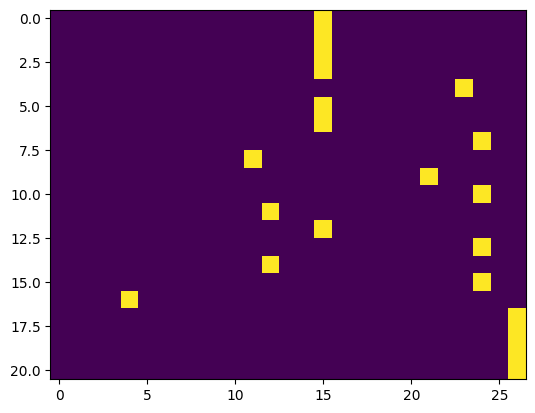

In [23]:
plt.imshow(np.array(one_hot_vectors)[310,:,:])

Now, let's explore the properties of the latent space of this dataset. Using ChaGPT:
- Write the AE using the encoded smiles as an input with 2D latent space
-  Visualize the latent distribution and representation
- Experiment with difefrent attributes from data frame as labels, and see how they are distirbuted in latent space

Epoch 1/50, Loss: 0.0754
Epoch 2/50, Loss: 0.0202
Epoch 3/50, Loss: 0.0200
Epoch 4/50, Loss: 0.0199
Epoch 5/50, Loss: 0.0197
Epoch 6/50, Loss: 0.0191
Epoch 7/50, Loss: 0.0178
Epoch 8/50, Loss: 0.0171
Epoch 9/50, Loss: 0.0169
Epoch 10/50, Loss: 0.0167
Epoch 11/50, Loss: 0.0165
Epoch 12/50, Loss: 0.0164
Epoch 13/50, Loss: 0.0163
Epoch 14/50, Loss: 0.0162
Epoch 15/50, Loss: 0.0161
Epoch 16/50, Loss: 0.0159
Epoch 17/50, Loss: 0.0158
Epoch 18/50, Loss: 0.0156
Epoch 19/50, Loss: 0.0155
Epoch 20/50, Loss: 0.0154
Epoch 21/50, Loss: 0.0153
Epoch 22/50, Loss: 0.0152
Epoch 23/50, Loss: 0.0152
Epoch 24/50, Loss: 0.0151
Epoch 25/50, Loss: 0.0151
Epoch 26/50, Loss: 0.0150
Epoch 27/50, Loss: 0.0150
Epoch 28/50, Loss: 0.0149
Epoch 29/50, Loss: 0.0149
Epoch 30/50, Loss: 0.0149
Epoch 31/50, Loss: 0.0148
Epoch 32/50, Loss: 0.0148
Epoch 33/50, Loss: 0.0147
Epoch 34/50, Loss: 0.0147
Epoch 35/50, Loss: 0.0147
Epoch 36/50, Loss: 0.0146
Epoch 37/50, Loss: 0.0145
Epoch 38/50, Loss: 0.0145
Epoch 39/50, Loss: 0.

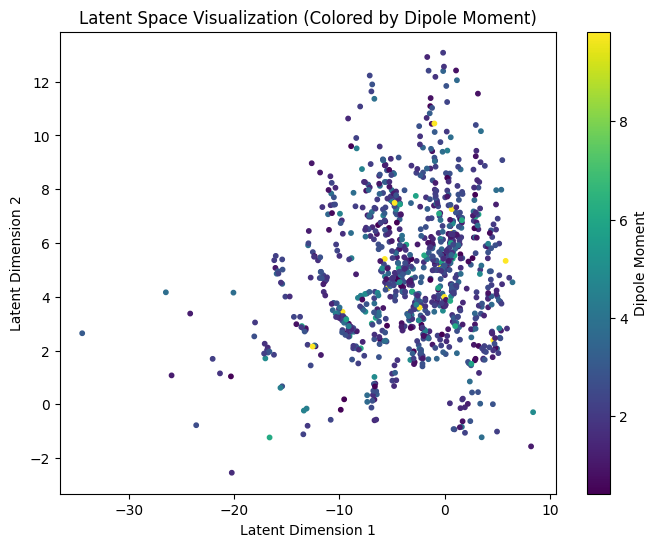

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define the Autoencoder
class AE2D(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super(AE2D, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed
# Normalize one-hot vectors for model input
one_hot_vectors = np.array(one_hot_vectors)
input_data = torch.tensor(one_hot_vectors, dtype=torch.float32)

# Split into training and testing sets
train_size = int(0.8 * len(input_data))
test_size = len(input_data) - train_size
train_data, test_data = torch.utils.data.random_split(input_data, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
# Initialize model, loss function, and optimizer
input_dim = input_data.shape[1] * input_data.shape[2]  # Flattened input dimension
model = AE2D(input_dim=input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.view(batch.size(0), -1)  # Flatten input
        optimizer.zero_grad()
        z, reconstructed = model(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")
# Extract latent representations
model.eval()
latents = []
labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.view(batch.size(0), -1)
        z, _ = model(batch)
        latents.append(z)
        labels.extend(df_filtered['dipole_moment'][:len(batch)])  # Example label: dipole moment

latents = torch.cat(latents).numpy()
labels = np.array(labels)

# Plot latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar(scatter, label='Dipole Moment')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization (Colored by Dipole Moment)')
plt.show()


Do the same with the VAE, also with 2D latent space

Epoch 1/50, Loss: 2860.5893
Epoch 2/50, Loss: 724.0693
Epoch 3/50, Loss: 707.0062
Epoch 4/50, Loss: 704.3802
Epoch 5/50, Loss: 703.6311
Epoch 6/50, Loss: 702.2214
Epoch 7/50, Loss: 702.1824
Epoch 8/50, Loss: 701.5858
Epoch 9/50, Loss: 700.7698
Epoch 10/50, Loss: 700.5784
Epoch 11/50, Loss: 700.2974
Epoch 12/50, Loss: 699.4350
Epoch 13/50, Loss: 699.9809
Epoch 14/50, Loss: 698.9900
Epoch 15/50, Loss: 698.6214
Epoch 16/50, Loss: 697.6919
Epoch 17/50, Loss: 696.6599
Epoch 18/50, Loss: 695.1298
Epoch 19/50, Loss: 694.3083
Epoch 20/50, Loss: 692.4928
Epoch 21/50, Loss: 692.9106
Epoch 22/50, Loss: 691.0160
Epoch 23/50, Loss: 690.9212
Epoch 24/50, Loss: 689.9920
Epoch 25/50, Loss: 689.7156
Epoch 26/50, Loss: 689.1899
Epoch 27/50, Loss: 690.0030
Epoch 28/50, Loss: 689.6451
Epoch 29/50, Loss: 689.4339
Epoch 30/50, Loss: 687.9691
Epoch 31/50, Loss: 688.8144
Epoch 32/50, Loss: 688.5578
Epoch 33/50, Loss: 687.9913
Epoch 34/50, Loss: 688.0339
Epoch 35/50, Loss: 688.0698
Epoch 36/50, Loss: 689.1640


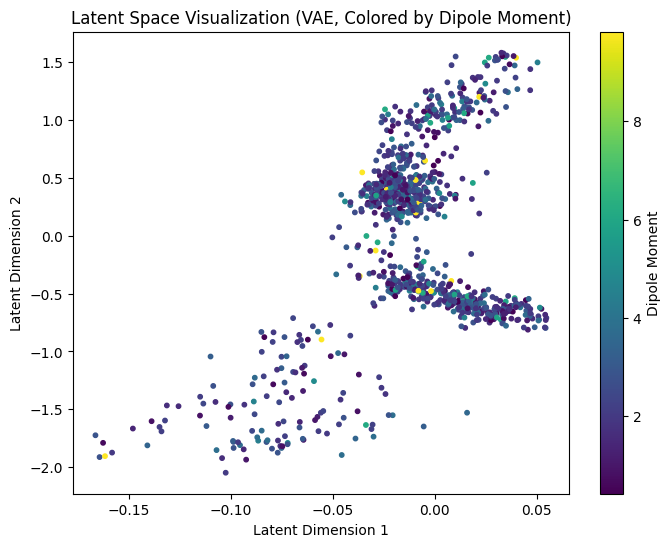

In [25]:
class VAE2D(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super(VAE2D, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.mu_layer = nn.Linear(64, latent_dim)
        self.logvar_layer = nn.Linear(64, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return z, x_reconstructed, mu, logvar
# Normalize and flatten the one-hot vectors
input_data = torch.tensor(one_hot_vectors, dtype=torch.float32)
train_size = int(0.8 * len(input_data))
test_size = len(input_data) - train_size
train_data, test_data = torch.utils.data.random_split(input_data, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

def vae_loss(reconstructed, x, mu, logvar):
    reconstruction_loss = nn.functional.mse_loss(reconstructed, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

input_dim = input_data.shape[1] * input_data.shape[2]
model = VAE2D(input_dim=input_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.view(batch.size(0), -1)  # Flatten input
        optimizer.zero_grad()
        z, reconstructed, mu, logvar = model(batch)
        loss = vae_loss(reconstructed, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

model.eval()
latents = []
labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.view(batch.size(0), -1)
        z, _, mu, _ = model(batch)
        latents.append(mu)
        labels.extend(df_filtered['dipole_moment'][:len(batch)])  # Example label: dipole moment

latents = torch.cat(latents).numpy()
labels = np.array(labels)

# Plot latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar(scatter, label='Dipole Moment')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization (VAE, Colored by Dipole Moment)')
plt.show()


Write the VAE with the 10D latent space. Suggest an approach to visualize the latent space

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

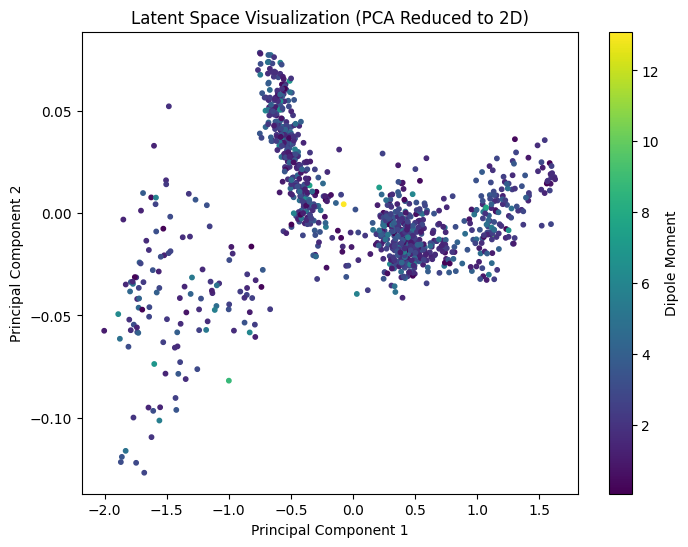

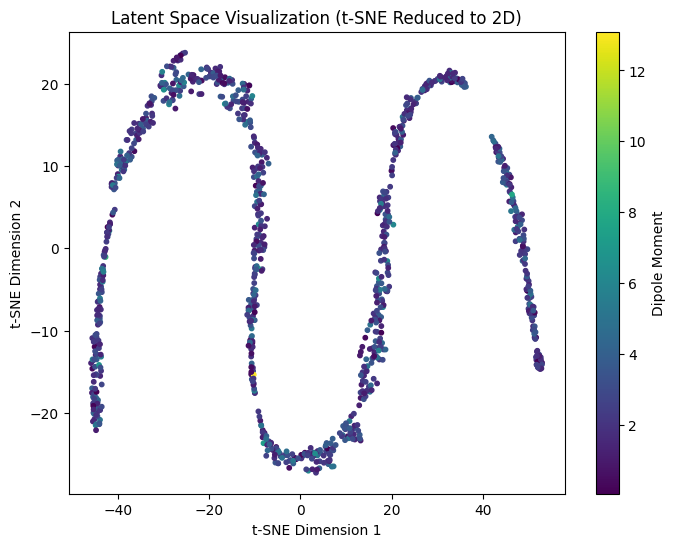

In [27]:
class VAE10D(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(VAE10D, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
        )
        self.mu_layer = nn.Linear(128, latent_dim)
        self.logvar_layer = nn.Linear(128, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return z, x_reconstructed, mu, logvar



# Collect latent representations
model.eval()
latents = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.view(batch.size(0), -1)
        z, _, mu, _ = model(batch)
        latents.append(mu)

latents = torch.cat(latents).numpy()

# Apply PCA
pca = PCA(n_components=2)
latents_pca = pca.fit_transform(latents)

# Plot PCA result
plt.figure(figsize=(8, 6))
plt.scatter(latents_pca[:, 0], latents_pca[:, 1], s=10, c=df_filtered['dipole_moment'][:len(latents)], cmap='viridis')
plt.colorbar(label='Dipole Moment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Latent Space Visualization (PCA Reduced to 2D)')
plt.show()



# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latents_tsne = tsne.fit_transform(latents)

# Plot t-SNE result
plt.figure(figsize=(8, 6))
plt.scatter(latents_tsne[:, 0], latents_tsne[:, 1], s=10, c=df_filtered['dipole_moment'][:len(latents)], cmap='viridis')
plt.colorbar(label='Dipole Moment')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Latent Space Visualization (t-SNE Reduced to 2D)')
plt.show()


Describe the difference between AE and VAE latent distirbutions

Answer:

Explore the variability of
- dipole momentum,
- number of rings
- mole log P over latent spaces.
What conclusions can you make?